In [1]:
import matplotlib.pyplot as plt

from dti_v3_data import *
from dti_v3_prep import *
from dti_v3_utils import *
from dti_v3_esoinn import *

In [2]:
save_version = 'test_v1'
dataClass = DataCreation('train')

catPrep = CatProcessing()
catPrep.save_one_hot_enc_model(dataClass.label_data, save_version)

strPrep = StrProcessing()
strPrep.save_tfidf_model_fit(dataClass.str_data, list(dataClass.str_data), (1, 1), 256, save_version)

prep_data = strPrep.load_tfidf_model_trans(dataClass.str_data, list(dataClass.str_data), 10000, save_version)
label_df = catPrep.trnsfm_one_hot_enc_data(dataClass.label_data, save_version)
data_dict = train_test_split(dataClass.index_data, prep_data, label_df)

NORMAL DATA START DATETIME:  2020-12-14 00:00:00
ATTACK DATA START DATETIME:  2020-12-14 00:00:00
DATA END DATETIME:  2021-12-14 00:00:00
DATA LIMIT:  10000
******* 정상 데이터 불러오기 *******
{'host': '192.168.0.42', 'port': '9001', 'timeout': '600000', 'thread': '10'}
DB client : <clickhouse_driver.client.Client object at 0x7ff3f917b610>
NORMAL DATA PROPERTIES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31416 entries, 0 to 31415
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype                     
---  ------  --------------  -----                     
 0   lgtime  31416 non-null  datetime64[ns, Asia/Seoul]
 1   src_ip  31416 non-null  object                    
 2   dst_ip  31416 non-null  object                    
 3   host    31416 non-null  object                    
 4   agent   31416 non-null  object                    
 5   query   31416 non-null  object                    
 6   label   31416 non-null  object                    
dtypes: datetime64[ns, Asia/Seo

In [3]:
X_train = data_dict['X_train'].reshape((data_dict['X_train'].shape[0], data_dict['X_train'].shape[1]))
print("X_train.shape :", X_train.shape)
Y_train = catPrep.inverse_transform(data_dict['Y_train'], save_version)
print("Y_train.shape :", Y_train.shape[0])

X_valdn = data_dict['X_valid'].reshape((data_dict['X_valid'].shape[0], data_dict['X_valid'].shape[1]))
print("X_valdn.shape :", X_valdn.shape)
Y_valdn = catPrep.inverse_transform(data_dict['Y_valid'], save_version)
print("Y_valdn.shape :", Y_valdn.shape[0])

X_test = data_dict['X_test'].reshape((data_dict['X_test'].shape[0], data_dict['X_test'].shape[1]))
print("X_test.shape :", X_test.shape)
Y_test = catPrep.inverse_transform(data_dict['Y_test'], save_version)
print("Y_test.shape :", Y_test.shape[0])

X_train.shape : (37678, 322)
Y_train.shape : 37678
X_valdn.shape : (10766, 322)
Y_valdn.shape : 10766
X_test.shape : (5383, 322)
Y_test.shape : 5383


In [4]:
iter_size = 450 # 300 # 500  # 1000
e_age = 50  #100, 200
# e_age = 150
epoch = 100

s = ESoinn(iteration_threshold=iter_size, max_edge_age=e_age)

s.check_point(
    save_version=save_version
    , monitor='accuracy'
    , save_best_only=True
    , save_plt_fig=False
    , patience=20
)
s.fit(
    train_data=[X_train, Y_train]
    , validation_data=[X_valdn, Y_valdn]
    , epochs=epoch
#     , full_shuffle_flag=False
)


tp: 4372 fn: 114 
fp: 3709 tn: 2571
epoch :    1 
accuracy : 0.6449 , precision : 0.5410 , recall : 0.9746 , f1_score : 0.6958
esoinn_model_test_v1_1.pickle saved


tp: 4303 fn: 183 
fp: 1916 tn: 4364
epoch :    2 
accuracy : 0.8050 , precision : 0.6919 , recall : 0.9592 , f1_score : 0.8039
esoinn_model_test_v1_2.pickle saved


tp: 4295 fn: 191 
fp: 1760 tn: 4520
epoch :    3 
accuracy : 0.8188 , precision : 0.7093 , recall : 0.9574 , f1_score : 0.8149
esoinn_model_test_v1_3.pickle saved


tp: 4281 fn: 205 
fp: 1452 tn: 4828
epoch :    4 
accuracy : 0.8461 , precision : 0.7467 , recall : 0.9543 , f1_score : 0.8379
esoinn_model_test_v1_4.pickle saved


tp: 4270 fn: 216 
fp: 1373 tn: 4907
epoch :    5 
accuracy : 0.8524 , precision : 0.7567 , recall : 0.9519 , f1_score : 0.8431
esoinn_model_test_v1_5.pickle saved


tp: 4280 fn: 206 
fp: 1533 tn: 4747
epoch :    6 
accuracy : 0.8385 , precision : 0.7363 , recall : 0.9541 , f1_score : 0.8311

tp: 4278 fn: 208 
fp: 1517 tn: 4763
epoch :   

ESoinn(dim=322, iteration_threshold=450)

<Figure size 432x288 with 0 Axes>

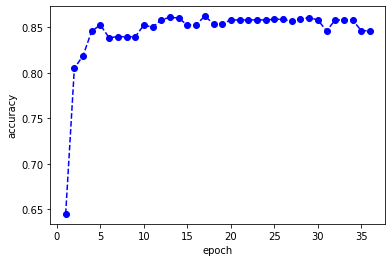

In [5]:
plt.plot([i + 1 for i in range(len(s.monitor_result_list[:-1]))], s.monitor_result_list[:-1], 'bo--')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.ylim(0.85, 1.0)
plt.axis('auto')
plt.show()

In [6]:
print("best_epoch :", s.max_idx_monitor_result)
best_epoch = s.max_idx_monitor_result

try:
    s.load_esoinn_model(save_version, best_epoch)
except Exception as er:
    print(er)
noise_idx_list, non_noise_list = s.predict(X_test)

acc = s.get_evaluation(Y_test, 'accuracy')

best_epoch : 17
esoinn_model load and initiated **************

tp: 2089 fn: 92 
fp: 603 tn: 2599
epoch :   17 
accuracy : 0.8709 , precision : 0.7760 , recall : 0.9578 , f1_score : 0.8574


In [7]:
test_res_list = []
idx = 0
for label in Y_test:
    tmp_res_arr = list(data_dict['IDX_test'][idx])
    pred = ""
    if idx in non_noise_list:
        pred += "normal"
    else:
        pred += "ATTACK"
    
    tmp_res_arr.append(label[0])
    tmp_res_arr.append(pred)
    tmp_res_arr.append(str(acc * 100))
    tmp_res_arr.append(str(best_epoch))
    tmp_res_arr.append(save_version)
    test_res_list.append(tmp_res_arr)
    idx += 1

# execute_ch("INSERT INTO dti.kisa_network_anomaly_detection_result VALUES", test_res_list)

In [8]:
with open("./output/network_anomaly_detection_result.csv", "w") as f:
    f.write("logtime, src_ip, dst_ip, ai_label_true, ai_label_pred, accuracy(%), best_epoch, version\n")
    for res_arr in test_res_list:
        tmp_line = ""
        for res_val in res_arr:
            tmp_line = tmp_line + str(res_val) + ","
        f.write(tmp_line[:-1] + "\n")